<div align="center">

## Multiclass Classification Project for CSGO Game Winner Prediction
### Autor : Vinh Tang

</div>

### Libraries import & Settings

In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.pyplot as plt
import pickle
from lazypredict.Supervised import LazyClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Both are used for feature selection in classification problems:
# f_classif: Used to evaluate the degree of association between numerical features and the classification target using ANOVA F-test (linear).
# chi2: Used to evaluate the degree of association between categorical features (encoded with positive numbers) and the classification target using Chi-squared test (based on frequency counts).
from sklearn.feature_selection import f_classif, chi2


In [2]:
pd.options.display.float_format = '{:.5f}'.format

### ML Pipeline

![image.png](ML_Pipeline.png)

### Step 1 : Data collection : skip because data is already available
### Step between step 1 and step 2: Importing data

In [3]:
df = pd.read_csv("csgo.csv", delimiter = ",")
df

,map,day,month,year,date,wait_time_s,match_time_s,team_a_rounds,team_b_rounds,ping,kills,assists,deaths,mvps,hs_percent,points,result
0,Mirage,3.00000,8.00000,2018.00000,3/8/2018,327.00000,2906.00000,16.00000,13.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000,Win
1,Mirage,2.00000,8.00000,2018.00000,2/8/2018,336.00000,2592.00000,16.00000,11.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000,Lost
2,Mirage,31.00000,7.00000,2018.00000,31/7/2018,414.00000,2731.00000,16.00000,14.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000,Win
3,Mirage,31.00000,7.00000,2018.00000,31/7/2018,317.00000,2379.00000,11.00000,16.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000,Lost
4,Mirage,30.00000,7.00000,2018.00000,30/7/2018,340.00000,3467.00000,15.00000,15.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000,Tie
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128,Dust II,23.00000,7.00000,2015.00000,23/7/2015,2.00000,1573.00000,16.00000,4.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000,Lost
1129,Dust II,23.00000,7.00000,2015.00000,23/7/2015,29.00000,2126.00000,16.00000,8.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000,Lost
1130,Dust II,23.00000,7.00000,2015.00000,23/7/2015,10.00000,2555.00000,11.00000,16.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000,Lost
1131,Dust II,23.00000,7.00000,2015.00000,23/7/2015,9.00000,2293.00000,8.00000,16.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000,Lost


Identify features and target for verifying by F-Statistics and P-value

In [4]:
# Identify target
target = "result"
x = df.drop(target, axis=1) # Split the X columns (feature columns)
y = df[target]

In [5]:
# Verfifie ANOVA

x_num = x.select_dtypes(include='number') 
f_values, p_values = f_classif(x_num, y)

for name, f, p in zip(x_num.columns, f_values, p_values):
    print(f"{name}: F = {f:.2f}, p = {p:.4f}")


day: F = 0.12, p = 0.8857
month: F = 0.45, p = 0.6389
year: F = 1.23, p = 0.2939
wait_time_s: F = 1.92, p = 0.1473
match_time_s: F = 86.66, p = 0.0000
team_a_rounds: F = 15.68, p = 0.0000
team_b_rounds: F = 19.31, p = 0.0000
ping: F = 0.01, p = 0.9887
kills: F = 63.41, p = 0.0000
assists: F = 14.97, p = 0.0000
deaths: F = 171.91, p = 0.0000
mvps: F = 65.85, p = 0.0000
hs_percent: F = 0.10, p = 0.9015
points: F = 72.33, p = 0.0000


**Explanation of ANOVA F-test (`f_classif`) Results for Numerical Features**

After applying the ANOVA F-test to evaluate the relationship between numerical features and the categorical target (e.g., win/loss/draw), we obtained the following results:

| Feature         | F-value | p-value | Explanation |
|-----------------|---------|---------|-------------|
| `day`           | 0.12    | 0.8857  | Not statistically significant (p > 0.05) → Unrelated to the target |
| `month`         | 0.45    | 0.6389  | Not significant → Likely unrelated to the target |
| `year`          | 1.23    | 0.2939  | Low impact |
| `wait_time_s`   | 1.92    | 0.1473  | Not statistically meaningful (p > 0.05) |
| `match_time_s`  | 86.66   | 0.0000  | Very important → Strongly impacts the target outcome |
| `team_a_rounds` | 15.68   | 0.0000  | Important → Shows a relationship with the target |
| `team_b_rounds` | 19.31   | 0.0000  | Similarly important as `team_a_rounds` |
| `ping`          | 0.01    | 0.9887  | Completely unrelated to the target |
| `kills`         | 63.41   | 0.0000  | Very important |
| `assists`       | 14.97   | 0.0000  | Statistically relevant to the target |
| `deaths`        | 171.91  | 0.0000  | Extremely important → Strong distinguishing power |
| `mvps`          | 65.85   | 0.0000  | Very important |
| `hs_percent`    | 0.10    | 0.9015  | Not statistically significant |
| `points`        | 72.33   | 0.0000  | Very important |



**Conclusion:**

**Features to **keep** (p-value < 0.05):**
- `match_time_s`
- `kills`
- `assists`
- `deaths`
- `mvps`
- `points`
- `ping` (thanks to domain knowledge although should remove according to p_value result)
- `hs_percent` (thanks to domain knowledge although should remove according to p_value result)

**Features to **consider removing** (p-value > 0.05):**
- `day`
- `month`
- `year`
- `date` (related to the three features above)
- `wait_time_s`
- `team_a_rounds` (thanks to domain knowledge although should keep according to p_value result)
- `team_b_rounds` (thanks to domain knowledge although should keep according to p_value result too)

**Feature to consider after:**
- `map` (Check the correlation with the target column after encoding both columns)

In [6]:
# Logically, the date, month, year values ​​and the team a, 
# team b columns do not affect the win, lose or draw results, so I delete them.

df.drop(columns=["day", "month", "year", "date", "team_a_rounds", "team_b_rounds", "wait_time_s"], axis=1, inplace=True)
df

,map,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points,result
0,Mirage,2906.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000,Win
1,Mirage,2592.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000,Lost
2,Mirage,2731.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000,Win
3,Mirage,2379.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000,Lost
4,Mirage,3467.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000,Tie
...,...,...,...,...,...,...,...,...,...,...
1128,Dust II,1573.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000,Lost
1129,Dust II,2126.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000,Lost
1130,Dust II,2555.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000,Lost
1131,Dust II,2293.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000,Lost


In [7]:
# Because the target column we choose here is the result column with text format (type nominal categories), 
# I have to encode it, first check its separate values
df["result"].unique()

array(['Win', 'Lost', 'Tie'], dtype=object)

Encode the target column using LabelEncoder in the sklearn.preprocessing library

In [8]:
le = LabelEncoder()
df["result"] = le.fit_transform(df["result"])
print(df["result"].unique())
df

[2 0 1]


,map,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points,result
0,Mirage,2906.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000,2
1,Mirage,2592.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000,0
2,Mirage,2731.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000,2
3,Mirage,2379.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000,0
4,Mirage,3467.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000,1
...,...,...,...,...,...,...,...,...,...,...
1128,Dust II,1573.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000,0
1129,Dust II,2126.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000,0
1130,Dust II,2555.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000,0
1131,Dust II,2293.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000,0


Explore the data

In [9]:
df.info(); df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   map           1133 non-null   object 
 1   match_time_s  1133 non-null   float64
 2   ping          1133 non-null   float64
 3   kills         1133 non-null   float64
 4   assists       1133 non-null   float64
 5   deaths        1133 non-null   float64
 6   mvps          1133 non-null   float64
 7   hs_percent    1133 non-null   float64
 8   points        1133 non-null   float64
 9   result        1133 non-null   int64  
dtypes: float64(8), int64(1), object(1)
memory usage: 88.6+ KB


,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points,result
count,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000,1133.00000
mean,2291.43866,72.49426,14.70609,4.15887,17.03442,1.82524,24.90203,39.21712,0.93645
std,474.52433,65.99597,5.94877,2.36348,4.79248,1.48770,13.67221,14.89802,0.96008
min,630.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1942.00000,31.00000,11.00000,2.00000,14.00000,1.00000,16.00000,29.00000,0.00000
50%,2311.00000,76.00000,14.00000,4.00000,18.00000,2.00000,23.00000,39.00000,1.00000
75%,2648.00000,92.00000,18.00000,6.00000,21.00000,3.00000,33.00000,49.00000,2.00000
max,3603.00000,724.00000,36.00000,14.00000,27.00000,8.00000,100.00000,89.00000,2.00000


In [10]:
print("\na) Filter and view the first two rows of the DataFrame :")
print(df.iloc[[0,1,2]]) # or df.iloc[:3]
print("\n")
print(f"\nb) Filter to get the first cell value of the ping column : {df.loc[2, 'ping']}")
print("\n")
print(f"\nc) Filter on demand (eg people with 10+ kills and 4+ headshots) : \n {df[(df['kills'] > 10) & (df['hs_percent'] > 4)]}")
print("\n")
print("\nd) Aggregate and view maps by the average value of two columns waiting time, matching time :")
df.groupby('map')[['match_time_s', 'ping']].mean()


a) Filter and view the first two rows of the DataFrame :
      map  match_time_s      ping    kills  assists   deaths    mvps  \
0  Mirage    2906.00000 215.00000 17.00000  2.00000 21.00000 2.00000   
1  Mirage    2592.00000 199.00000 13.00000  4.00000 24.00000 2.00000   
2  Mirage    2731.00000  85.00000 15.00000  3.00000 18.00000 3.00000   

   hs_percent   points  result  
0     5.00000 45.00000       2  
1     0.00000 40.00000       0  
2    26.00000 37.00000       2  



b) Filter to get the first cell value of the ping column : 85.0



c) Filter on demand (eg people with 10+ kills and 4+ headshots) : 
           map  match_time_s      ping    kills  assists   deaths    mvps  \
0      Mirage    2906.00000 215.00000 17.00000  2.00000 21.00000 2.00000   
2      Mirage    2731.00000  85.00000 15.00000  3.00000 18.00000 3.00000   
3      Mirage    2379.00000  93.00000 12.00000  2.00000 15.00000 2.00000   
4      Mirage    3467.00000  94.00000 33.00000  5.00000 20.00000 5.00000   
5  

,match_time_s,ping
map,,
Austria,2513.00000,70.00000
Cache,2357.44068,76.89831
Canals,2189.00000,126.00000
Cobblestone,2528.08333,51.08333
Dust II,2265.24863,82.25411
Inferno,2320.99242,43.12121
Italy,1899.00000,34.00000
Mirage,2303.54821,69.81818
Nuke,2500.75000,30.25000


Visualisation

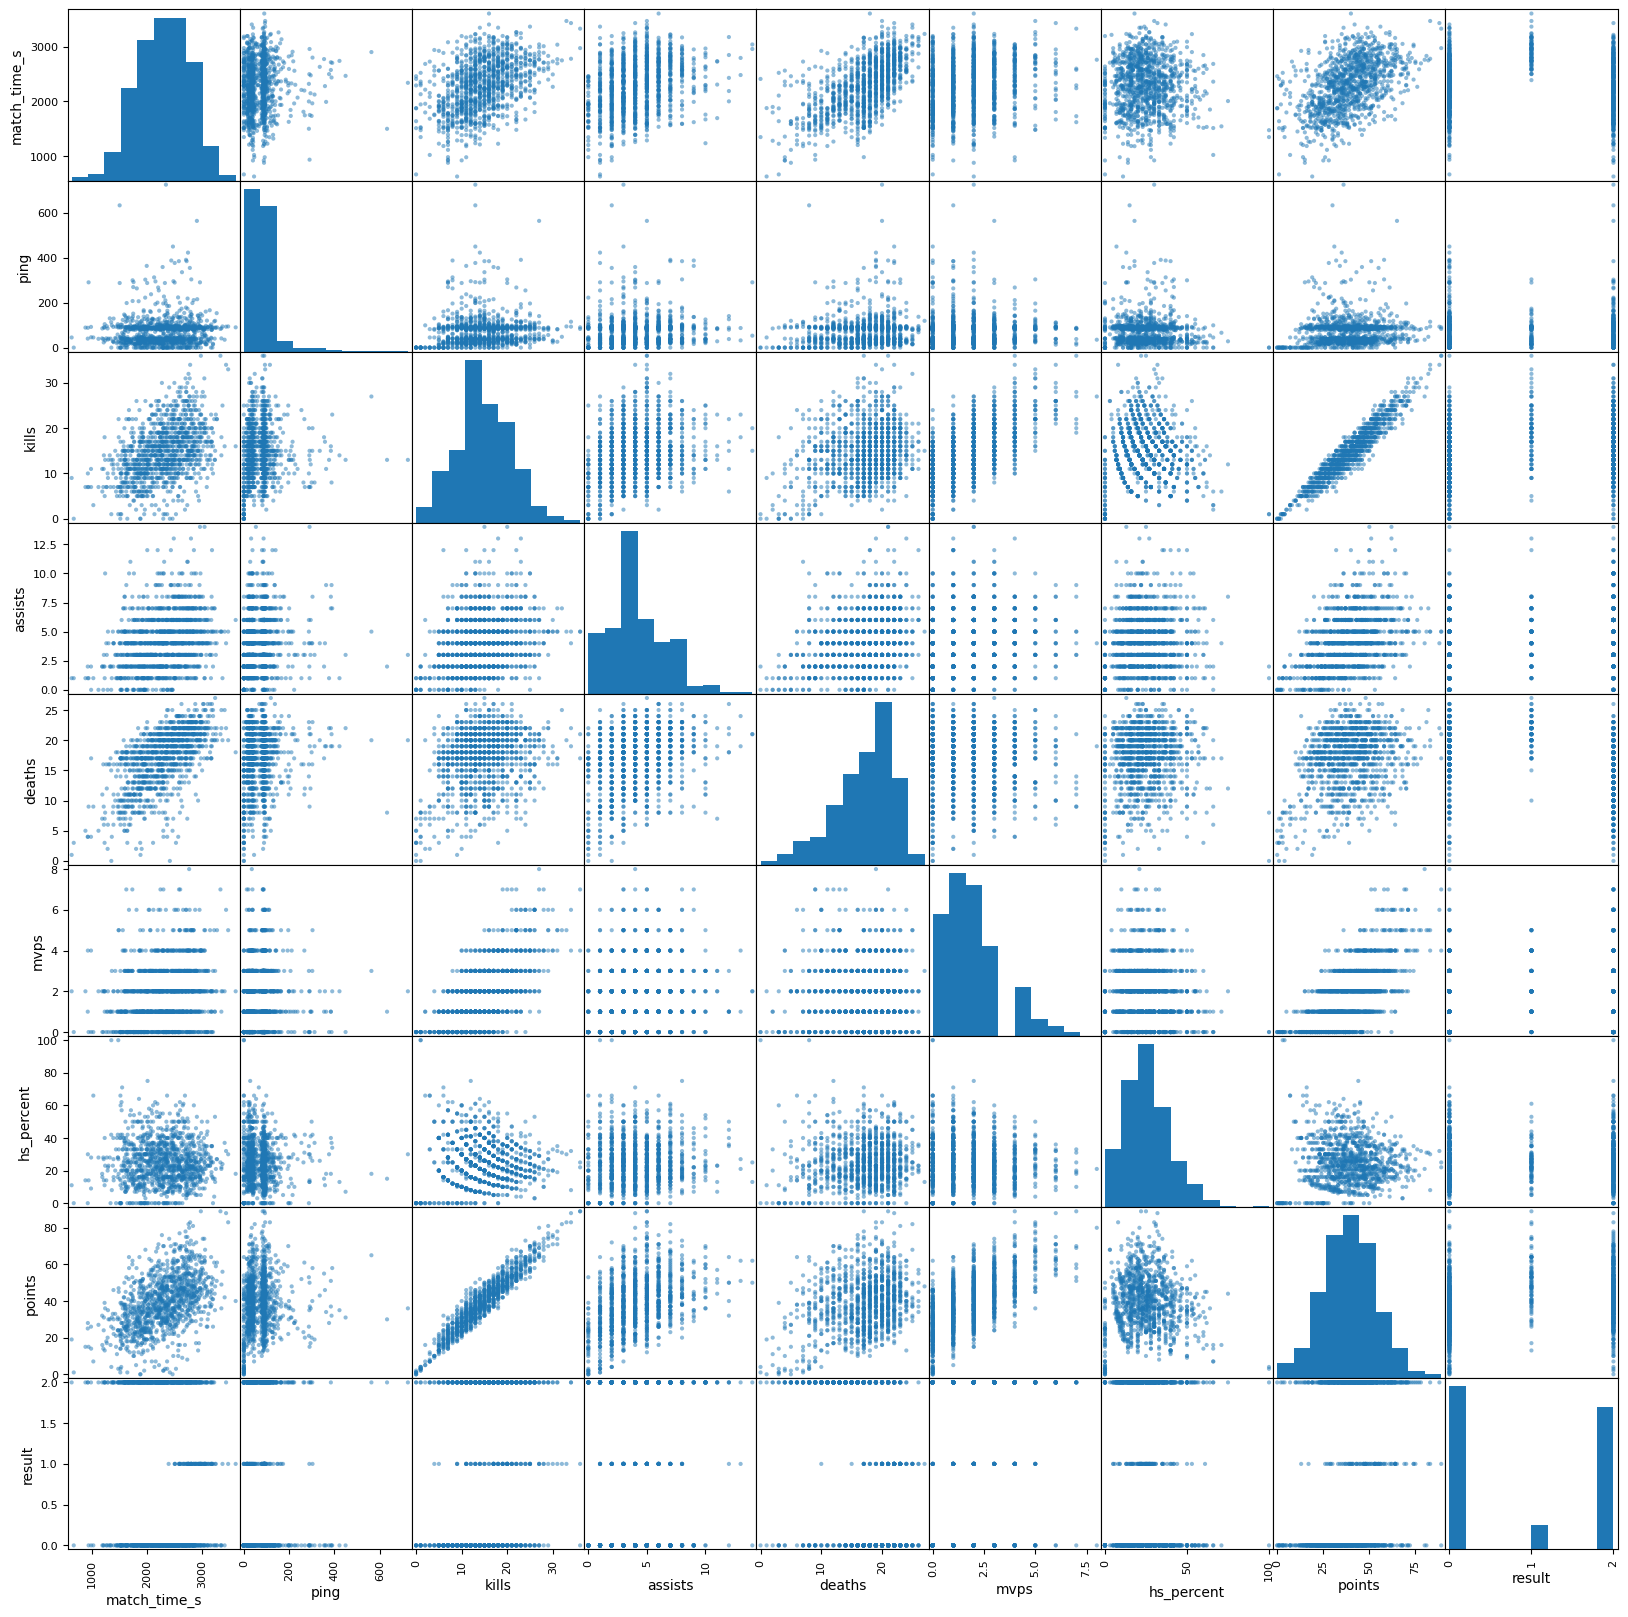

In [11]:
# Scatter matrix
scatter_matrix(df, figsize = (20,20))
plt.show()

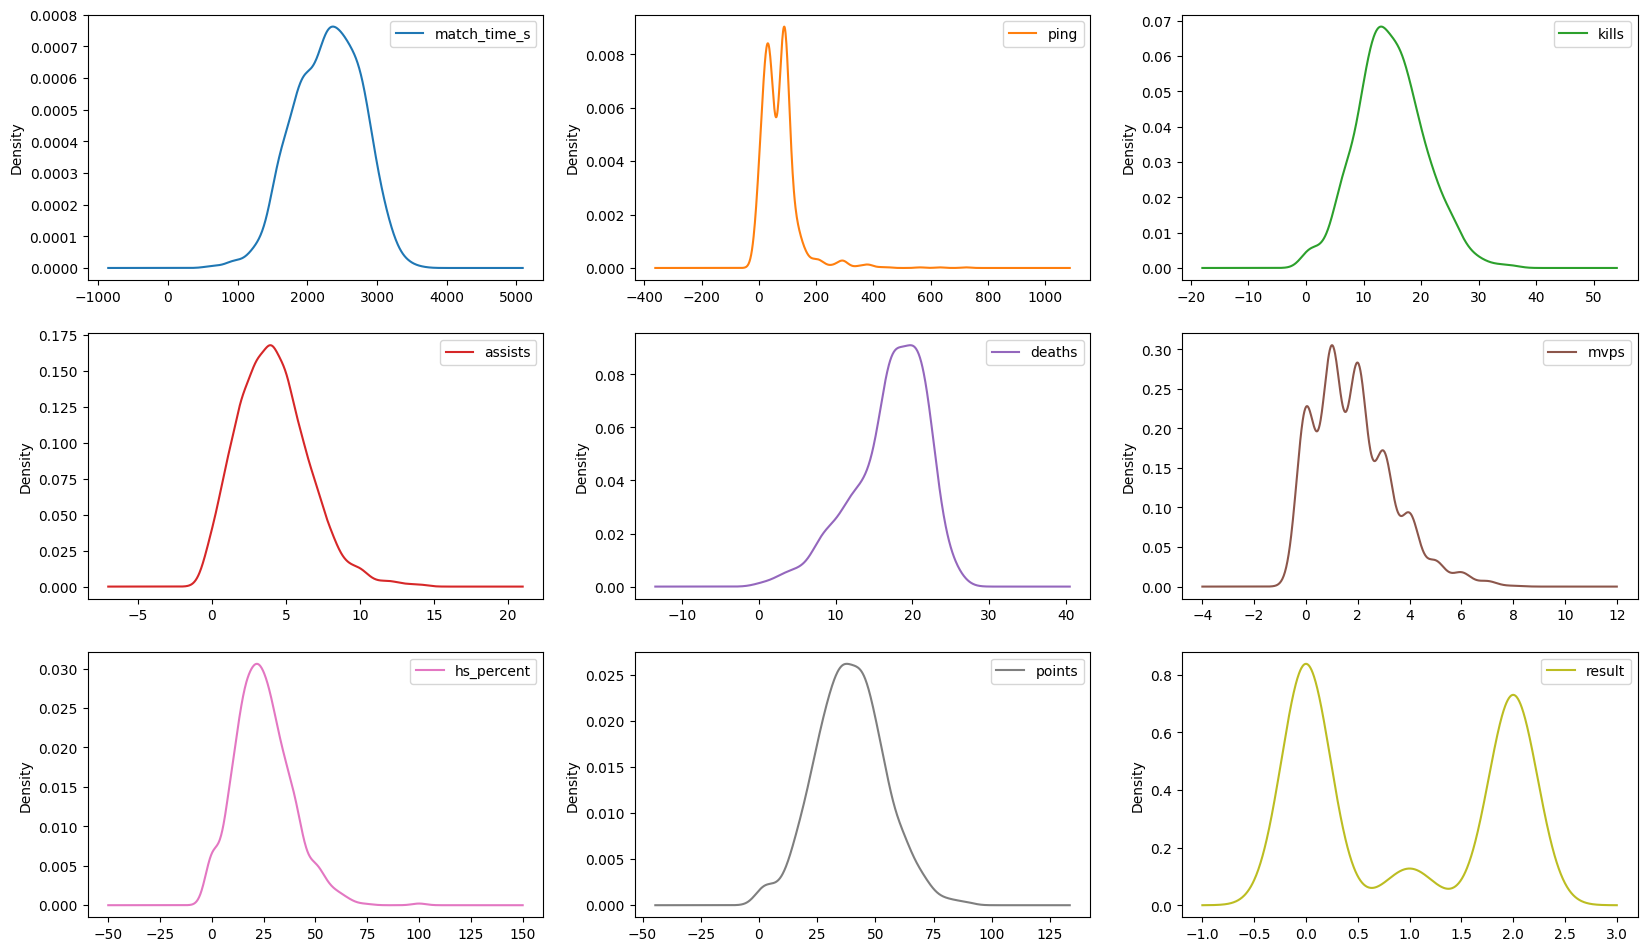

In [12]:
# Density chart
df.plot(kind='density', subplots=True, layout=(5,3), figsize = (20,20), sharex=False);

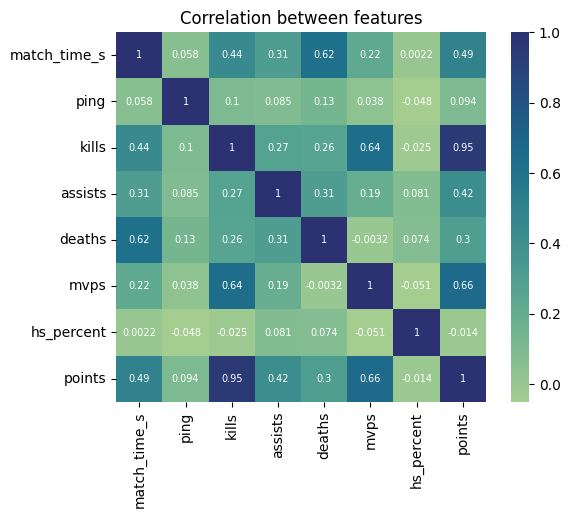

In [13]:
# Correlation matrix

df_numeric_except_target = df.select_dtypes(include='number').drop(columns='result', errors='ignore') # remove target column because it is essentially a categorical column

sns.heatmap(df_numeric_except_target.corr(), annot=True, cmap='crest', square=True, annot_kws={"size" : 7, "c" : "w"})
plt.title("Correlation between features")
plt.show()

In [14]:
# After using it, comment it out so it runs only once, 
# that's enough because it only shows us the unprocessed data at first.

# from ydata_profiling import ProfileReport

# profile = ProfileReport(df, title="Classification - CSGO Report")
# profile.to_file("Classification_CSGO_Report.html")

### Step before data preprocessing step (step 3): data division step

Identify features and target for verifying by F-Statistics and P-value

In [15]:
# Identify target
target = "result"
x = df.drop(target, axis=1) # Split the X columns (feature columns)
y = df[target]

Identify train set, validation test and test set

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Step 3 : Data pre-processing
#### Step 3.0 : MULTI-COLLINEARITY Test

Use **Variance Inflation Factor** (*VIF*) to test. 

*VIF* > 5 (or > 10) → severe multicollinearity

In [17]:
X = df[["match_time_s", "ping", "kills", "assists", "deaths", "mvps", "hs_percent", "points"]]  # numerical features
X = add_constant(X)

vif = pd.DataFrame()
vif["feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

,feature,VIF
0,const,28.90748
1,match_time_s,1.97091
2,ping,1.03116
3,kills,14.54186
4,assists,1.64630
5,deaths,1.79269
6,mvps,1.94982
7,hs_percent,1.02013
8,points,18.22227


=> I see that the VIF scores of the series "kills" and "points" are very high, meaning that these two series are multicollinear.

=> To handle columns with Multicollinearity : 

- Method 1: Delete one of the two variables (I use this method now)
- Method 2: Create a composite feature
- Method 3: Use a model that is not sensitive to multicollinearity

In [18]:
x


,map,match_time_s,ping,kills,assists,deaths,mvps,hs_percent,points
0,Mirage,2906.00000,215.00000,17.00000,2.00000,21.00000,2.00000,5.00000,45.00000
1,Mirage,2592.00000,199.00000,13.00000,4.00000,24.00000,2.00000,0.00000,40.00000
2,Mirage,2731.00000,85.00000,15.00000,3.00000,18.00000,3.00000,26.00000,37.00000
3,Mirage,2379.00000,93.00000,12.00000,2.00000,15.00000,2.00000,16.00000,30.00000
4,Mirage,3467.00000,94.00000,33.00000,5.00000,20.00000,5.00000,30.00000,83.00000
...,...,...,...,...,...,...,...,...,...
1128,Dust II,1573.00000,46.00000,12.00000,2.00000,20.00000,0.00000,16.00000,26.00000
1129,Dust II,2126.00000,41.00000,19.00000,6.00000,21.00000,2.00000,31.00000,51.00000
1130,Dust II,2555.00000,17.00000,9.00000,3.00000,20.00000,2.00000,55.00000,30.00000
1131,Dust II,2293.00000,20.00000,11.00000,4.00000,20.00000,1.00000,27.00000,31.00000


In [19]:
x = x.drop(columns="kills", axis = 1) # or drop "points" if you want to keep "kills"
x

,map,match_time_s,ping,assists,deaths,mvps,hs_percent,points
0,Mirage,2906.00000,215.00000,2.00000,21.00000,2.00000,5.00000,45.00000
1,Mirage,2592.00000,199.00000,4.00000,24.00000,2.00000,0.00000,40.00000
2,Mirage,2731.00000,85.00000,3.00000,18.00000,3.00000,26.00000,37.00000
3,Mirage,2379.00000,93.00000,2.00000,15.00000,2.00000,16.00000,30.00000
4,Mirage,3467.00000,94.00000,5.00000,20.00000,5.00000,30.00000,83.00000
...,...,...,...,...,...,...,...,...
1128,Dust II,1573.00000,46.00000,2.00000,20.00000,0.00000,16.00000,26.00000
1129,Dust II,2126.00000,41.00000,6.00000,21.00000,2.00000,31.00000,51.00000
1130,Dust II,2555.00000,17.00000,3.00000,20.00000,2.00000,55.00000,30.00000
1131,Dust II,2293.00000,20.00000,4.00000,20.00000,1.00000,27.00000,31.00000


In [20]:
# Split again the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

#### Step 3.1 : Preprocessing NUMERICAL FEATURE

It includes columns like `wait_time_s, match_time_s, ping, kills, assists, deaths, mvps, hs_percent, points`

In [21]:
num_transformer = Pipeline(steps= [("imputer", SimpleImputer(strategy="mean")),
                                   ("scaler", RobustScaler())])

processed_num_data = num_transformer.fit_transform(x_train[[ "match_time_s", 
                                                            "ping", "assists", "deaths",
                                                            "mvps", "hs_percent", "points"]])

for idx, (i,j) in enumerate(zip(x_train[["match_time_s", "ping", "assists", "deaths", "mvps", "hs_percent", "points"]].values, processed_num_data)) :
    if idx >= 5 :
        break
    print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is [2.336e+03 1.960e+02 2.000e+00 1.800e+01 0.000e+00 0.000e+00 2.200e+01], processed data is [ 0.06426554  2.10699588 -0.66666667  0.         -1.         -1.29577465
 -0.84210526]
1, not processed data is [2557.   92.    6.   16.    6.   16.   62.], processed data is [ 0.37641243  0.39506173  0.66666667 -0.28571429  2.         -0.3943662
  1.26315789]
2, not processed data is [1.515e+03 0.000e+00 1.000e+00 6.000e+00 0.000e+00 0.000e+00 3.000e+00], processed data is [-1.09533898 -1.11934156 -1.         -1.71428571 -1.         -1.29577465
 -1.84210526]
3, not processed data is [2.492e+03 8.800e+01 9.000e+00 2.000e+01 1.000e+00 2.200e+01 5.600e+01], processed data is [ 0.28460452  0.32921811  1.66666667  0.28571429 -0.5        -0.05633803
  0.94736842]
4, not processed data is [2976.   25.    3.   24.    0.   14.   34.], processed data is [ 0.96822034 -0.70781893 -0.33333333  0.85714286 -1.         -0.50704225
 -0.21052632]


#### Step 3.2 : Preprocessing CATEGORICAL ORDINAL

It includes `map` column

In [22]:
nominal_transformer = Pipeline(steps =[("imputer", SimpleImputer(strategy="most_frequent")), 
                                       ("nom_encoder", OneHotEncoder(sparse_output=False, handle_unknown= 'ignore'))])

processed_nominal_data = nominal_transformer.fit_transform(x_train[["map"]])

for idx, (i,j) in enumerate(zip(x_train[["map"]].values, processed_nominal_data)):
    if idx < 10:
        print(f'{idx}, not processed data is {i}, processed data is {j}')

0, not processed data is ['Cache'], processed data is [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
1, not processed data is ['Dust II'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
2, not processed data is ['Inferno'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
3, not processed data is ['Dust II'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
4, not processed data is ['Dust II'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
5, not processed data is ['Dust II'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
6, not processed data is ['Inferno'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
7, not processed data is ['Dust II'], processed data is [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
8, not processed data is ['Inferno'], processed data is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
9, not processed data is ['Mirage'], processed data is [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


Check the relevance between feature "map" and target column

In [23]:
chi_scores, p_values = chi2(processed_nominal_data, y_train)
print("Chi-squared scores:", chi_scores)
print("p-values:", p_values)

Chi-squared scores: [0.99120879 0.59256572 1.34108527 1.63561989 0.47424059 0.3845017
 0.99120879 0.18265883 0.99120879 2.50064819]
p-values: [0.6092026  0.74357707 0.51143098 0.44139728 0.78889638 0.82509987
 0.6092026  0.912717   0.6092026  0.28641196]


Because all of p-values is big, I decide to remove this categorical feature

#### Step 3.3 : Conclusion

In [24]:
preprocessor = ColumnTransformer(transformers=[
    ("num_features", num_transformer, ["match_time_s", "ping", "assists", "deaths", "mvps", "hs_percent", "points"])
    # ("nominal_features", nominal_transformer, ["map"])
])

preprocessor

ColumnTransformer(transformers=[('num_features',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', RobustScaler())]),
                                 ['match_time_s', 'ping', 'assists', 'deaths',
                                  'mvps', 'hs_percent', 'points'])])

In [25]:
step_preprocessing = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

processed_data = step_preprocessing.fit_transform(x_train)
view_processed_data = pd.DataFrame(processed_data)
view_processed_data

,0,1,2,3,4,5,6
0,0.06427,2.10700,-0.66667,0.00000,-1.00000,-1.29577,-0.84211
1,0.37641,0.39506,0.66667,-0.28571,2.00000,-0.39437,1.26316
2,-1.09534,-1.11934,-1.00000,-1.71429,-1.00000,-1.29577,-1.84211
3,0.28460,0.32922,1.66667,0.28571,-0.50000,-0.05634,0.94737
4,0.96822,-0.70782,-0.33333,0.85714,-1.00000,-0.50704,-0.21053
...,...,...,...,...,...,...,...
901,-0.56144,-0.36214,-0.33333,-0.14286,-1.00000,-0.11268,-0.26316
902,-0.83686,-0.59259,0.00000,-0.14286,-1.00000,0.11268,-0.10526
903,0.37359,-0.83951,-0.33333,0.28571,0.00000,1.80282,-0.42105
904,0.24788,0.08230,0.66667,0.28571,-0.50000,0.11268,0.52632


### Step 5: Choose a model

I observe that the target column **does not** have a strong correlation with the two numerical features. Therefore, my first thought is to choose a non-linear model such as `K-Nearest Neighbors`, `Decision Tree`, `Random Forest`, or `Support Vector Machine`.

Selected model: `RandomForestClassifier` in library `sklearn.ensemble`

In [26]:
model1 = ImbPipeline(steps = [
    ("preprocessor", preprocessor),
    ('smote', SMOTE(random_state=42)),
    ("classifier", RandomForestClassifier(class_weight='balanced' ,random_state=42))
])

params = {
    "classifier__n_estimators": [50,100,200],
    "classifier__criterion" : ["gini", "entropy", "log_loss"],
    "classifier__max_depth": [None, 5, 10, 20],
    "classifier__min_samples_split" : [2, 5],
    "preprocessor__num_features__imputer__strategy" : ["median", "mean"]
}

scores = {
    'precision_macro': 'precision_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted',
    'roc_auc_ovr': 'roc_auc_ovr',
    'roc_auc_ovo': 'roc_auc_ovo'
}

gridsearchcv_model1 = GridSearchCV(model1, param_grid= params , scoring = scores, refit = 'roc_auc_ovr' , cv=4, verbose = 2, n_jobs=-1)


I let the machine learn and predict based on model1 by GridSearchCV

In [27]:
gridsearchcv_model1.fit(x_train, y_train);

Fitting 4 folds for each of 144 candidates, totalling 576 fits


Since I used **multi-metrics scoring** to put in the scoring parameter, now I have to print out the metrics sets with the best performance to choose from, by default I have set **refit = roc_auc_ovr** if there is any better metric then I will change it

In [28]:
results = pd.DataFrame(gridsearchcv_model1.cv_results_)

# Get scoring columns
score_cols = sorted([col for col in results.columns if col.startswith('mean_test_')])

# Find the best index of each metric
best_indices = {col: results[col].idxmax() for col in score_cols}

# Generate a summary table of the best metrics and their corresponding params
summary_rows = []

for col in score_cols:
    idx = best_indices[col]
    summary_rows.append({
        'metric': col.replace('mean_test_', ''),
        'score': results[col][idx],
        'params': results['params'][idx]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by='score', ascending=False)
print(summary_df)

               metric   score  \
4         roc_auc_ovr 0.88133   
3         roc_auc_ovo 0.88024   
1  precision_weighted 0.77625   
2     recall_weighted 0.72851   
0     precision_macro 0.63828   

                                              params  
4  {'classifier__criterion': 'gini', 'classifier_...  
3  {'classifier__criterion': 'entropy', 'classifi...  
1  {'classifier__criterion': 'entropy', 'classifi...  
2  {'classifier__criterion': 'entropy', 'classifi...  
0  {'classifier__criterion': 'entropy', 'classifi...  


In [29]:
# Since GridSearchCV is based on the Cross-validation principle, these are the scores based on the VALIDATION set
print(gridsearchcv_model1.best_estimator_)
print(gridsearchcv_model1.best_params_)
print(gridsearchcv_model1.best_score_) 
print(gridsearchcv_model1.best_index_)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   RobustScaler())]),
                                                  ['match_time_s', 'ping',
                                                   'assists', 'deaths', 'mvps',
                                                   'hs_percent', 'points'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])
{'classifier__criterion': 'gini', 'cl

#### pickle library :
library used to save and load everything

In [30]:
filename = 'model.pkl'
pickle.dump(gridsearchcv_model1,open('model.pkl', 'wb'))

### Step 6: Model evaluating


In [31]:
# Recall models from pickle
model_from_pickle = pickle.load(open('model.pkl','rb'))

y_predict1 = model_from_pickle.predict(x_test)

In [32]:
for idx, (i,j) in enumerate(zip(y_predict1, y_test)):
    if idx >= 10 :
        break
    print(f'{idx}, Giá trị dự đoán là {i}, giá trị thực tế là {j}')

0, Giá trị dự đoán là 2, giá trị thực tế là 0
1, Giá trị dự đoán là 2, giá trị thực tế là 2
2, Giá trị dự đoán là 2, giá trị thực tế là 2
3, Giá trị dự đoán là 0, giá trị thực tế là 0
4, Giá trị dự đoán là 1, giá trị thực tế là 1
5, Giá trị dự đoán là 1, giá trị thực tế là 0
6, Giá trị dự đoán là 0, giá trị thực tế là 2
7, Giá trị dự đoán là 2, giá trị thực tế là 2
8, Giá trị dự đoán là 1, giá trị thực tế là 0
9, Giá trị dự đoán là 2, giá trị thực tế là 2


In [33]:
print(f"The Accuracy score of the entire test set is : {accuracy_score(y_test, y_predict1)}")
print(f"The Precision score of the entire test set is  : {precision_score(y_test, y_predict1, average='weighted')}")
print(f"The Recall score of the entire test set is : {recall_score(y_test, y_predict1, average='weighted')}")
print(f"The F1 score of the entire test set is: {f1_score(y_test, y_predict1, average='weighted')}")


The Accuracy score of the entire test set is : 0.6960352422907489
The Precision score of the entire test set is  : 0.7221551883765895
The Recall score of the entire test set is : 0.6960352422907489
The F1 score of the entire test set is: 0.7055911605752251


In [34]:
print(f"Report is : \n {classification_report(y_test, y_predict1)}")


Report is : 
               precision    recall  f1-score   support

           0       0.73      0.69      0.71       105
           1       0.34      0.57      0.43        21
           2       0.80      0.73      0.76       101

    accuracy                           0.70       227
   macro avg       0.62      0.66      0.63       227
weighted avg       0.72      0.70      0.71       227



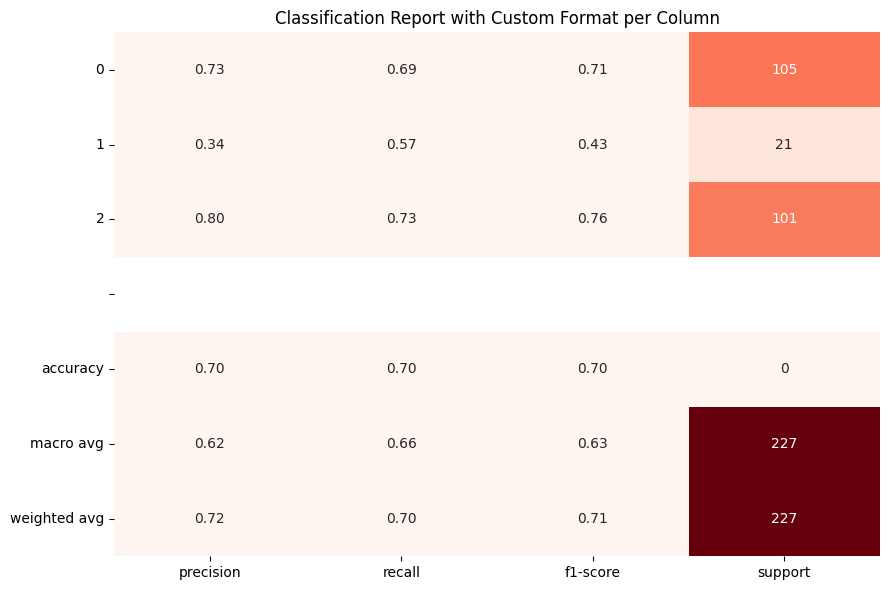

In [35]:
report = classification_report(y_test, y_predict1, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_report['support'] = df_report['support'].astype(int)
blank_row = pd.DataFrame([[np.nan, np.nan, np.nan, np.nan]], index=[''], columns=['precision', 'recall', 'f1-score', 'support'])
class_labels = [idx for idx in df_report.index if idx.isdigit()]
summary_labels = ['accuracy', 'macro avg', 'weighted avg']
df_plot = pd.concat([
    df_report.loc[class_labels],
    blank_row,
    df_report.loc[summary_labels]
])
# Tạo ma trận chuỗi định dạng riêng biệt cho từng cột
annot = df_plot.copy().astype(str)

for row in annot.index:
    for col in annot.columns:
        val = df_plot.loc[row, col]
        if pd.isna(val):
            annot.loc[row, col] = ''
        elif col == 'support':
            annot.loc[row, col] = f"{val:.0f}"  # không có thập phân
        else:
            annot.loc[row, col] = f"{val:.2f}"  # 2 chữ số thập phân

# Vẽ heatmap với chuỗi định dạng riêng
plt.figure(figsize=(9, 6))
sns.heatmap(df_plot, annot=annot.values, fmt="", cmap="Reds", cbar=False)
plt.title("Classification Report with Custom Format per Column")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

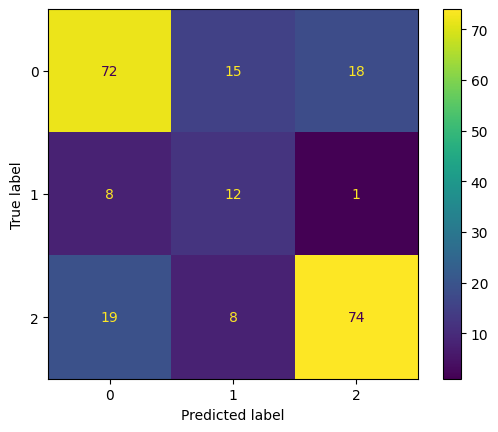

In [36]:
cm = confusion_matrix(y_test, y_predict1, labels=gridsearchcv_model1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=gridsearchcv_model1.classes_)
disp.plot()

### (BONUS 1) Another way to approach data modeling and data evaluation phases : LazyPredict library

LazyPredict function in lazypredict library is fast train function in Machine Learning Supervised and return 30-40 suitable models

In [37]:
applied_step_preprocessing_to_features = Pipeline(steps= [
    ("preprocessor", preprocessor)
])

x_train_for_lazypredict = applied_step_preprocessing_to_features.fit_transform(x_train)
x_test_for_lazypredict = applied_step_preprocessing_to_features.transform(x_test) # Principle: only transform on the test set
    

clf = LazyClassifier(verbose=2, ignore_warnings=True, random_state=42)
clf.use_notebook_tqdm = False # Disable tqdm in Jupyter
models, predictions = clf.fit(x_train_for_lazypredict, x_test_for_lazypredict, y_train, y_test)

  0%|          | 0/32 [00:00<?, ?it/s]

{'Model': 'AdaBoostClassifier', 'Accuracy': 0.6960352422907489, 'Balanced Accuracy': np.float64(0.5996542511393996), 'ROC AUC': None, 'F1 Score': 0.690888124573017, 'Time taken': 0.16067719459533691}
{'Model': 'BaggingClassifier', 'Accuracy': 0.6960352422907489, 'Balanced Accuracy': np.float64(0.5872072921577872), 'ROC AUC': None, 'F1 Score': 0.6896847383703154, 'Time taken': 0.05104517936706543}
{'Model': 'BernoulliNB', 'Accuracy': 0.5859030837004405, 'Balanced Accuracy': np.float64(0.4925035360678925), 'ROC AUC': None, 'F1 Score': 0.6170172257661295, 'Time taken': 0.010016679763793945}
{'Model': 'CalibratedClassifierCV', 'Accuracy': 0.7092511013215859, 'Balanced Accuracy': np.float64(0.5336162187647336), 'ROC AUC': None, 'F1 Score': 0.6833058893973739, 'Time taken': 0.060655832290649414}
{'Model': 'DecisionTreeClassifier', 'Accuracy': 0.6475770925110133, 'Balanced Accuracy': np.float64(0.5397139713971397), 'ROC AUC': None, 'F1 Score': 0.6465815299792531, 'Time taken': 0.0157539844512

In [38]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.60793,0.66139,None,0.64818,0.01051
XGBClassifier,0.75771,0.65780,None,0.75443,0.13144
PassiveAggressiveClassifier,0.63436,0.62122,None,0.61195,0.01037
LGBMClassifier,0.74009,0.61946,None,0.73369,2.21299
QuadraticDiscriminantAnalysis,0.71366,0.61248,None,0.71208,0.00861
AdaBoostClassifier,0.69604,0.59965,None,0.69089,0.16068
BaggingClassifier,0.69604,0.58721,None,0.68968,0.05105
KNeighborsClassifier,0.70485,0.58036,None,0.69760,0.01927
RandomForestClassifier,0.71366,0.57489,None,0.70314,0.17258


In [39]:
models_sorted = models.sort_values(by=["Balanced Accuracy","Time Taken"], ascending=[False, True]) # I use Balanced Accuracy because this is imbalanced data and want to evaluate fairness between classes và muốn đánh giá công bằng giữa các lớp

view_lazypredict_models = pd.DataFrame(models_sorted)
view_lazypredict_models[["Balanced Accuracy", "Time Taken"]] = view_lazypredict_models[["Balanced Accuracy", "Time Taken"]].apply(pd.to_numeric, errors='coerce')

view_lazypredict_models.style.format({
    "Balanced Accuracy": "{:.5f}",
    "Time Taken": "{:.5f}"
})

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.607930,0.66139,None,0.648180,0.01051
XGBClassifier,0.757709,0.65780,None,0.754433,0.13144
PassiveAggressiveClassifier,0.634361,0.62122,None,0.611946,0.01037
LGBMClassifier,0.740088,0.61946,None,0.733688,2.21299
QuadraticDiscriminantAnalysis,0.713656,0.61248,None,0.712083,0.00861
AdaBoostClassifier,0.696035,0.59965,None,0.690888,0.16068
BaggingClassifier,0.696035,0.58721,None,0.689685,0.05105
KNeighborsClassifier,0.704846,0.58036,None,0.697605,0.01927
RandomForestClassifier,0.713656,0.57489,None,0.703144,0.17258


### (BONUS 2) Quickly check other models through Accuracy, ROC AUC, F1 Score

In [40]:
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVC": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB()
}

results = []

for name, model in models.items():
    model.fit(x_train_for_lazypredict, y_train)
    y_pred = model.predict(x_test_for_lazypredict)
    
    try:
        y_proba = model.predict_proba(x_test_for_lazypredict)
        auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    except:
        auc = None
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    results.append([name, acc, auc, f1])

df = pd.DataFrame(results, columns=["Model", "Accuracy", "ROC AUC", "F1 Score"])
df = df.sort_values("Accuracy", ascending=False)
print(df)


          Model  Accuracy  ROC AUC  F1 Score
2           SVC   0.74009  0.87304   0.71034
0  RandomForest   0.71366  0.87800   0.70059
1  DecisionTree   0.66079  0.67962   0.66002
3           KNN   0.66079  0.78867   0.64957
4    GaussianNB   0.62115  0.81304   0.63551


<div align="center">

### - END -

</div>
